## <center>Мини-проект. Полный анализ данных и построение прогнозной модели модели 
<center> Автор: Григорий Демин

В рамках данного задания используется набор данных по директ-маркетингу португальского банка. Ссылка: [Bank Marketing Data Set](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). 

In [35]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


__Описание набора данных__

Данные описывают директ-маркетинговую кампанию португальского банка. Кампания заключалась в обзвоне клиентов и предложения им депозита. Достаточно часто одному и тому же клиенту делалось несколько звонков.
Целью задачи является предсказание, воспользуется ли клиент депозитом или нет.


__Список переменных:__
* 1 - Возраст (шкала)
* 2 - job : Род занятий (номинальная: "admin." (админ. персонал),"unknown" (неизвестно),"unemployed" (безработный),"management" (менеджмент),"housemaid" (домохозяйка),"entrepreneur" (предприниматель),"student" (учащийся),"blue-collar" (служащий),"self-employed" (самозанятый),"retired" (пенсионер),"technician","services" (сервис) 
* 3 - marital : Семейное положение (номинальная: "married" (женат/замужем),"divorced" (разведен(а)/вдова/вдовец),"single" (одинокий))
* 4 - education: Образование (номинальная: "unknown" (неизвестно),"secondary" (среднее),"primary" (начальное),"tertiary" (высшее))
* 5 - default: была ли просрочка по кредиту? (бинарная: "yes" (да),"no" (нет))
* 6 - balance: среднегодовой баланс на счету, в евро (число) 
* 7 - housing: есть ли ипотека? (бинарная: "yes" (да),"no" (нет))
* 8 - loan: есть ли личные кредиты? (бинарная: "yes" (да),"no" (нет))
* _далее переменные, связанные с предыдущими контактами с данным клиентом:_
* 9 - contact: тип коммуникации (номинальная: "unknown" (неизвестно),"telephone" (стационарный телефон),"cellular"(сотовый)) 
* 10 - day: число месяца, когда был последний контакт (число)
* 11 - month: месяц, когда был последний контакт (Номинальная: "jan", "feb", "mar", ..., "nov", "dec")
* 12 - duration: длительность последнего контакта, в секундах (число)
* _другие атрибуты:_
* 13 - campaign: количество контактов, которое было с данным клиентом в данной кампании (число, включает последний контакт)
* 14 - pdays: количество дней, которое прошло с последнего контакта данной кампании (число, -1 обозначает, что ранее контактов не было)
* 15 - previous: количество контактов, которое было с данным клиентом до этой кампании (число)
* 16 - poutcome: результат предыдущей кампании (номинальная: "unknown" (неизвестно),"other" (другое),"failure" (неудача),"success" (успех))

  Целевая переменная:
  17 - y: Открыл ли клиент депозит? (бинарная: 1, 0)

In [36]:
data = pd.read_csv("../../data/bank.csv")

In [37]:
data.head() 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


**Выводим основные харакетристики переменных;**

In [38]:
print(data.shape)
data.describe(include = "all").T

(4521, 17)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,4521,NaN,NaN,NaN,41.1701,10.5762,19,33,39,49,87
job,4521,12,management,969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,4521,3,married,2797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,4521,4,secondary,2306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,4521,2,no,4445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,4521,NaN,NaN,NaN,1422.66,3009.64,-3313,69,444,1480,71188
housing,4521,2,yes,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,4521,2,no,3830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,4521,3,cellular,2896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,4521,NaN,NaN,NaN,15.9153,8.24767,1,9,16,21,31


In [39]:
# частотки по категориальным переменным
categorical = ["marital","education","default","housing","loan","contact","month","poutcome"]
for each_var in categorical:
    print('********')
    print('*',each_var,'*')
    print(data[each_var].value_counts())


********
* marital *
married     2797
single      1196
divorced     528
Name: marital, dtype: int64
********
* education *
secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64
********
* default *
no     4445
yes      76
Name: default, dtype: int64
********
* housing *
yes    2559
no     1962
Name: housing, dtype: int64
********
* loan *
no     3830
yes     691
Name: loan, dtype: int64
********
* contact *
cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64
********
* month *
may    1398
jul     706
aug     633
jun     531
nov     389
apr     293
feb     222
jan     148
oct      80
sep      52
mar      49
dec      20
Name: month, dtype: int64
********
* poutcome *
unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64


Делаем визуализацию:

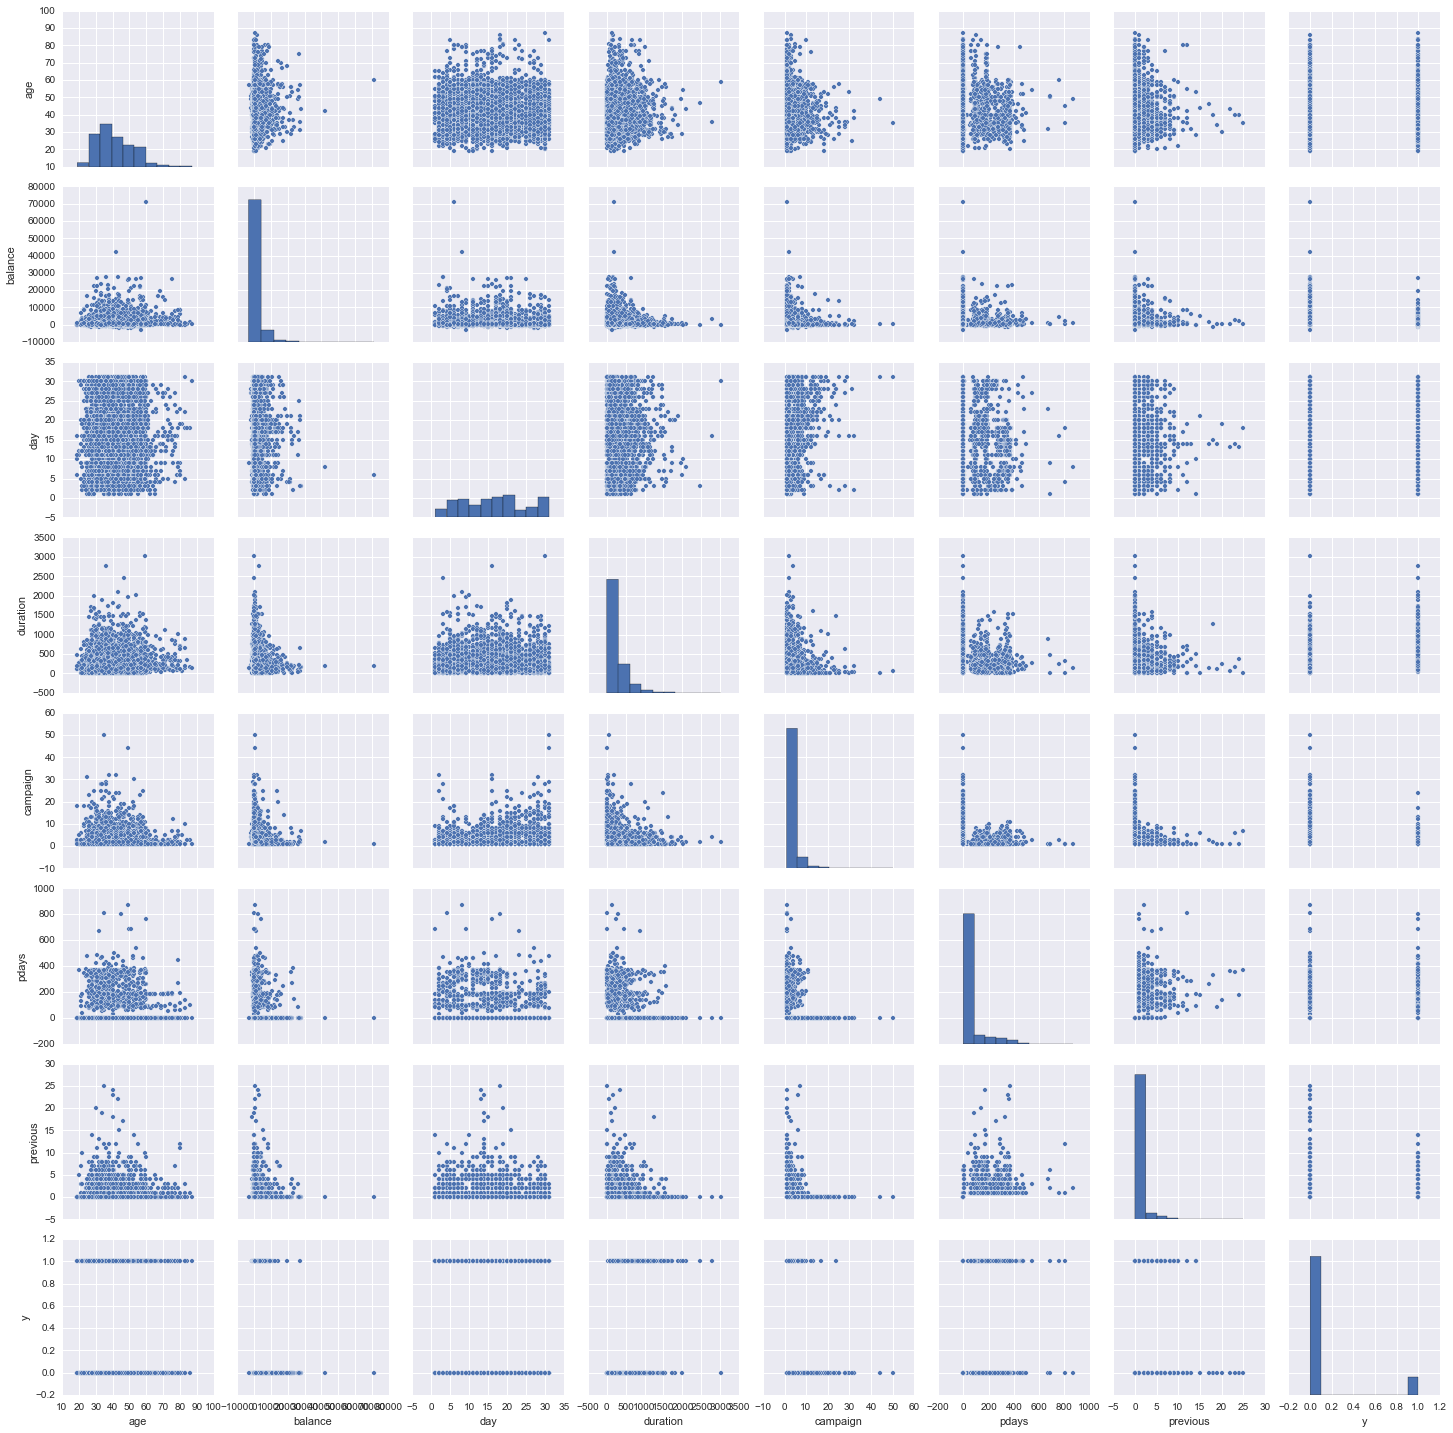

In [40]:
sns.pairplot(data)

Далее предобработка данных. 
* Удалим переменную duration - это длительность последнего контакта, если она равна нулю, то явно, что успеха не было. Из-за этого у неё хорошая прогнозная сила, но её значение не известно до звонка.
* pdays - количество дней, прошедшее с последнего звонка. Если -1, то звонка не было. Соответсвенно, перекодируем -1 в отдельную переменную - "Был звонок/не был", а в исходной переменной -1 заменим на медиану.
* В дополнение к непрерывному возрасту сделаем еще возраст категориальный.
* Перекодируем все категориальные переменные в dummies (0,1).
* Масштабируем все переменные.
* Разобъем выборку на тестовую и обучающую.

In [41]:
### Обрабатываем pdays:
first_call = (data.pdays == -1).astype(int)
first_call.name = "first_call"
data.pdays[data.pdays==-1] = NaN
data.pdays = data.pdays.fillna(value = data.pdays.median())
### Делаем возрастные категории
age1 = (data.age<25).astype(int)
age2 = (data.age>50).astype(int)
age1.name = "age1"
age2.name = "age2"


In [42]:
### dummy переменные:
data_dummies = pd.concat([
                        pd.get_dummies(data.job     , prefix = 'job'),
                        pd.get_dummies(data.marital , prefix = 'marital'),
                        pd.get_dummies(data.education, prefix = 'education'),
                        pd.get_dummies(data.default , prefix = 'default'),
                        pd.get_dummies(data.housing , prefix = 'housing'),
                        pd.get_dummies(data.loan , prefix = 'loan'),
                        pd.get_dummies(data.contact , prefix = 'contact'),
                        pd.get_dummies(data.month   , prefix = 'month'),
                        pd.get_dummies(data.poutcome, prefix = 'poutcome'),
                        data.age            ,
                        data.balance        ,
                        data.day            ,
                        data.campaign       ,
                        data.pdays          ,
                        data.previous       ,
                        first_call,
                        age1,
                        age2], axis=1)

Разбиваем на тестовую и обучающую выборку

In [43]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_dummies, data.y, 
                                                    test_size=0.3, 
                                                    random_state=20160212,
                                                   stratify = data.y)

Масштабируем переменные

In [44]:
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)
### Конвертируем назад в Pandas DataFrame
X_train = pd.DataFrame(X_train)
X_train.columns = data_dummies.columns
X_test = pd.DataFrame(X_test)
X_test.columns = data_dummies.columns

**Посмотрим на baseline - классификацию случайным лесом без настройки параметров.**

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
forest = RandomForestClassifier(n_estimators=500)
forest.fit(X_train, y_train)
test_pred = forest.predict(X_test)

Убедимся в том, что для данной задачи доля правильных ответов не будет хорошей метрикой качества модели.

In [53]:
accuracy_score(y_test, test_pred)

0.88209285187914521

Однако, лучшее качество дает даже тривиальный прогноз, что клиент не откроет депозит.

In [59]:
y_test.value_counts()[0] / y_test.shape[0]

0.88504053058216658

In [54]:
f1_score(y_test, test_pred)

0.19999999999999996

In [55]:
confusion_matrix(y_test, test_pred)

array([[1177,   24],
       [ 136,   20]])

**Выберем наиболее важные переменные**

In [45]:
forest = RandomForestClassifier(n_estimators=1000, max_depth = 5,
                                random_state=42).fit(X_train, y_train)

features = pd.DataFrame(forest.feature_importances_,
                        index=X_train.columns, 
                        columns=['Importance']).sort(['Importance'], 
                                                     ascending=False)
features

,Importance
poutcome_success,0.191042
pdays,0.097593
age,0.081435
month_oct,0.050307
balance,0.048373
previous,0.046243
housing_no,0.038301
housing_yes,0.036910
day,0.034847
poutcome_unknown,0.032847


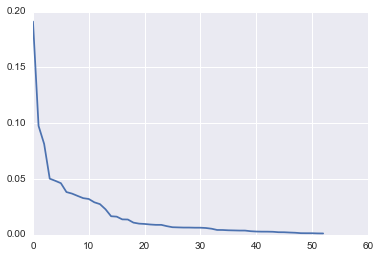

In [46]:
plt.plot(range(len(features.Importance.tolist())), 
         features.Importance.tolist())

Выбираем 20 признаков. Конвертируем выборки в Numpy матрицы.

In [47]:
selected_attr = features.index.tolist()[0:20]
X_train = X_train[selected_attr].as_matrix()
X_test = X_test[selected_attr].as_matrix()

Попробуем четыре разных классификатора: логистическую регрессию, Gradient boosting, Random Forest и SVM. Так как у нас сильный дисбаланс в выборке (успехов только 10%), то в качестве меры будем использовать F1 score.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

classifiers = [LogisticRegression(),
               GradientBoostingClassifier(), 
               RandomForestClassifier(), 
               SVC()]
classifiers_name = ["LogisticRegression",
               "GradientBoostingClassifier", 
               "RandomForestClassifier", 
               "SVC"]


Настраиваем параметры выбранных алгоритмов с помощью GridSearchCV и выбираем лучший классификатор.

In [50]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

n_folds = 5
scores = []
fits = []
logistic_params = {'penalty': ('l1', 'l2'), 
               'C': (.01,.1,1,5)}
gbm_params = { 'n_estimators': [100, 300, 500],
               'learning_rate':(0.1, 0.5, 1),
                'max_depth': list(range(3, 6)), 
               'min_samples_leaf': list(range(10, 31, 10))}
forest_params = {'n_estimators': [100, 300, 500],
                'criterion': ('gini', 'entropy'), 
               'max_depth': list(range(3, 6)), 
               'min_samples_leaf': list(range(10, 31, 10))}

svm_param = {'kernel' : ('linear', 'rbf'),
              'C': (.5, 1, 2)           
             }
params = [logistic_params, gbm_params, forest_params, svm_param]

# Проводим кросс-валидацию для всех моделей
for i, each_classifier in enumerate(classifiers):
    clf = each_classifier
    clf_params = params[i]
    grid = GridSearchCV(clf, clf_params, 
                        cv=StratifiedKFold(y_train, n_folds=n_folds,
                        shuffle=False, random_state=42), 
                        n_jobs=-1, scoring="f1")
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    clf_best_score = grid.best_score_
    scores.append(clf_best_score)
    print(classifiers_name[i], clf_best_score, "\n", grid.best_params_)

LogisticRegression 0.285764946893 
 {'penalty': 'l2', 'C': 1}
GradientBoostingClassifier 0.33721536848 
 {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10}
RandomForestClassifier 0.237165995878 
 {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
SVC 0.272895656452 
 {'kernel': 'linear', 'C': 0.5}
Лучший классификатор при GridSearch: GradientBoostingClassifier 0.33721536848
{'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10}


In [ ]:
# Печатаем параметры лучшего
grid_value = max(scores)
grid_index = [i for i in xrange(len(scores)) if scores[i]==grid_value][0]
print("Лучший классификатор при GridSearch:",
      classifiers_name[grid_index], grid_value)
print(fits[grid_index])

**Для лучшего классификатора и набора параметров для него выберем более мелкую сетку (для того чтобы уточнить лучшие значения параметров).**

In [ ]:
clf_params = {'n_estimators': (250, 300, 350), 
              'learning_rate': (0.75, 1, 1.25, 1.5), 
              'min_samples_leaf': list(range(1, 14, 3))}

clf = classifiers[grid_index]
grid = GridSearchCV(clf, clf_params, cv=n_folds, 
                    n_jobs=-1, scoring="f1")
grid.fit(X_train, y_train)
clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
clf_best = grid.best_estimator_
mean_validation_scores = []
print("Лучший результат", clf_best_score, 
      "лучшие параметры", clf_best_params)

**Строим график кривой обучения**

In [131]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

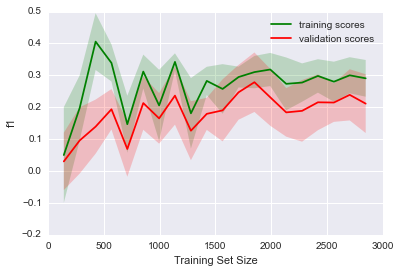

In [132]:
plot_learning_curve(GradientBoostingClassifier(n_estimators=2, 
                    learning_rate=1.5, min_samples_leaf=7),
                   X_train, y_train, scoring='f1', cv=10)

**Построим валидационную кривую для данных параметров бустинга. В качестве параметра сложности будем использовать learning_rate:**

In [117]:
from sklearn.learning_curve import validation_curve

def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

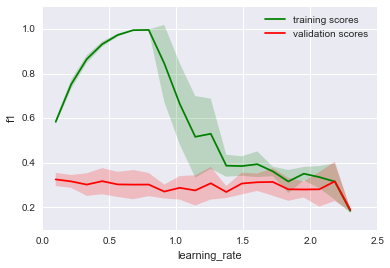

In [121]:
learning_rates = np.linspace(0.1, 2.3, 20)
plot_validation_curve(GradientBoostingClassifier(n_estimators=250, 
                    min_samples_leaf=7), X_train, y_train, 
                      cv_param_name='learning_rate', 
                      cv_param_values=learning_rates,
                   scoring='f1')

In [134]:
final_gbm = GradientBoostingClassifier(n_estimators=250, 
                    min_samples_leaf=7, learning_rate=1.5)
final_gbm.fit(X_train, y_train)
final_pred = final_gbm.predict(X_test)
accuracy_score(y_test, final_pred), f1_score(y_test, final_pred)

(0.86735445836403835, 0.22413793103448273)

__Выводы.__

Построена модель предсказания, согласится ли респондент на банковский продукт. Модель предсказывает с 87%-ной долей правильных ответов на отложенных 30% выборки. Но accuracy не очень хорошо характеризует качество модели из-за сильного дисбаланса в целевой переменной (~90% против ~10%), поэтому в качестве целевой была выбрана метрика F1-score. На отложенной выборке удалось добиться только F1=0.22.
Построены кривые обучения и валидационные кривые. К сожалению, у них наблюдается некоторая немонотонность, однако видно, что увеличение количества примеров более 2000 не приносит существенной выгоды (у нас в обучающей выборке более 3000 примеров). Из валидационного графика видно, что learning rate = 1.5, выбранный с помощью перебора на обучающей выборки, близок к оптимальному.  